In [23]:
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
import math

In [29]:
KE = 50 #kinetic energy of electrons kev
planck_c = 4.135667516e-15 #planck constant
m0 = 9.10938215e-31 #rest mass of electron
speed_light = 299792458 #Speed of light
lambda_e = (planck_c*speed_light/(math.sqrt(KE*1000*(KE*1000+2*m0*speed_light**2*6.241506363e+18)))); print(lambda_e)

#Defining the detector parameters this can be adapted from the experiment
xcen = 391.55 #center of the diffraction
ycen = 393.03 #center of the diffraction
pixel_size = 4.8e-5 #size of the pixel
shape_det = [900,900]
distanceDet = 0.5 # in m
wavel = lambda_e; 

5.3553082697833555e-12


In [30]:
#Defining the detector in pyFAI
import pyFAI.detectors

detector = pyFAI.detectors.Detector(pixel1=pixel_size, pixel2=pixel_size,max_shape=(900,900))
ai = AzimuthalIntegrator(dist=distanceDet, detector=detector, wavelength=wavel)
ai.setFit2D(directDist=500,centerX=xcen,centerY=ycen)

print(ai)

Detector Detector	 Spline= None	 PixelSize= 4.800e-05, 4.800e-05 m
Wavelength= 5.355308e-12m
SampleDetDist= 5.000000e-01m	PONI= 1.886544e-02, 1.879440e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 500.000mm	Center: x=391.550, y=393.030 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg


H:\My Documents\GitHub\Electron-diffraction\diffraction_modified_scattering_glycerol_isolated.png


(-0.5, 433.5, 433.5, -0.5)

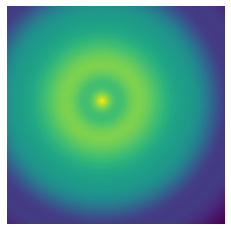

In [31]:
import cv2
import os
import matplotlib.pyplot as plt
file_path = os.path.join(os.getcwd(),'diffraction_modified_scattering_glycerol_isolated.png')
print(file_path)
image = cv2.imread(file_path,0)
plt.imshow(image)
plt.axis('off')

Text(0, 0.5, 'Itot (Arb-units)')

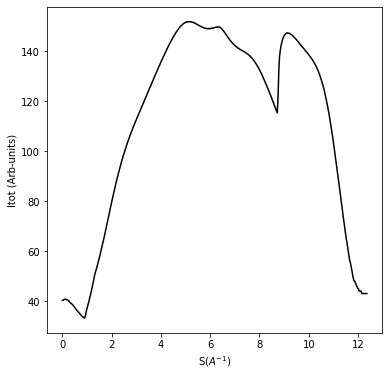

In [33]:
#azimuthal integration using the intergate1d method
#the default radial unit is “q_nm^1”, so the scattering vector length expressed in inverse nanometers. 
#To be able to calculate q, one needs to specify the wavelength used
res = ai.integrate1d(image, 800)

#The ds in stuart's code is calculated as ds = (2*np.pi*pixelSize*radialDist[0])/(wavel*distanceDet)
#here I believe that is done by 2*pi*pixel_size/(wavel/distanceDet)
sx = res[0]*.198
Itot = res[1]

#Display the integration result
plt.figure(figsize=(6,6))
plt.plot(sx,Itot, color = 'black')

plt.xlabel('S($A^{-1}$)')
plt.ylabel('Itot (Arb-units)')

Text(0, 0.5, 'Itot (Arb-units)')

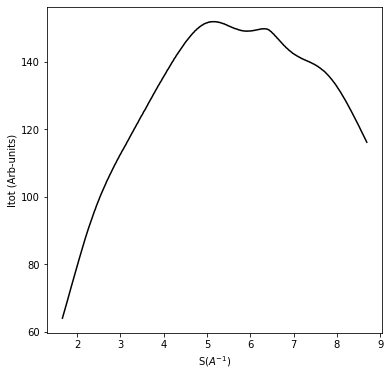

In [34]:
s_cut = []
I_cut = []
for s,I in zip(sx,Itot):
    if s>=1.65 and s<=8.7:
        s_cut.append(s)
        I_cut.append(I)
    else:
        continue
#print(s_cut)
#print(I_cut)
plt.figure(figsize=(6,6))
plt.plot(s_cut,I_cut, color = 'black')
plt.xlabel('S($A^{-1}$)')
plt.ylabel('Itot (Arb-units)')

In [35]:
#Background being subtracted after fitting the Itot to a cubic polynomial
from scipy.optimize import curve_fit
def fit_poly(x,a,b,c,d):
    y = a*x**3+b*x**2+c*x+d
    return y
popt, pcov = curve_fit(fit_poly, s_cut, I_cut)
print(popt)

[  0.19210236  -7.70582976  69.57720911 -30.84521677]


(1.4, 9.0)

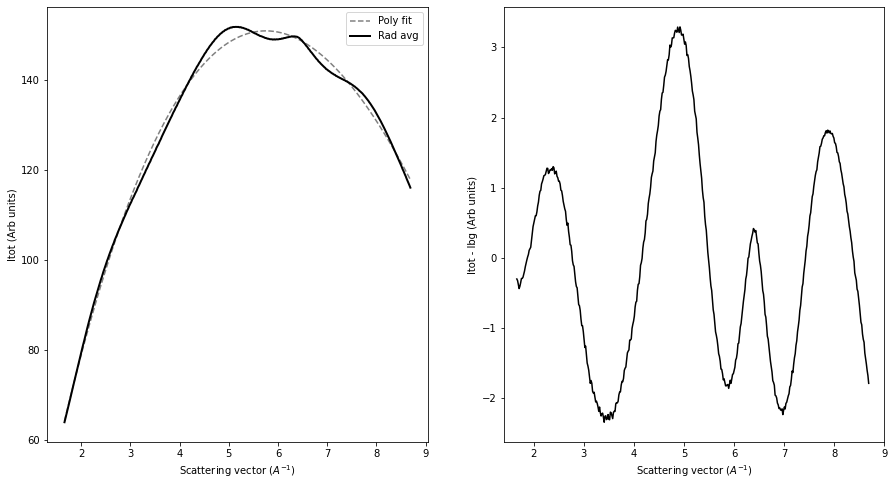

In [37]:
import numpy as np
y =[]
for item in s_cut:
    y.append(fit_poly(item,popt[0],popt[1],popt[2],popt[3]))
    
s_ms =  np.subtract(I_cut,y)

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.plot(s_cut,y,color = 'gray', ls = '--')
plt.plot(s_cut,I_cut,color = 'black', lw =2)
plt.legend(['Poly fit','Rad avg'])
plt.ylabel('Itot (Arb units)')
plt.xlabel('Scattering vector ($A^{-1}$)')
plt.subplot(1,2,2)
plt.plot(s_cut,s_ms, color = 'black')
plt.ylabel('Itot - Ibg (Arb units)')
plt.xlabel('Scattering vector ($A^{-1}$)')
plt.xlim([1.4,9])

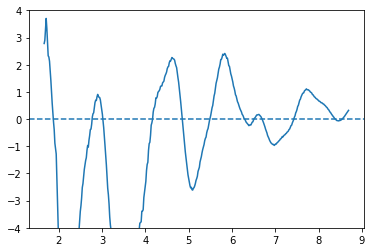

In [39]:
import math
Dl =[]

for l,Ik in zip(s_cut,s_ms):
    dl = 0
    for s in s_cut:
         dl = dl+Ik*(math.sin(s*l))/(s*l)
    Dl.append(dl)

plt.plot(s_cut,Dl)
plt.ylim([-4,4])
plt.axhline(0,ls='--')